In [55]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from collections import Counter
import itertools
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [70]:
#读取原始数据
df = pd.read_csv('.\dataset_diabetes\proprecessing_data_readmitted.csv')
readmitted = np.array(df.loc[:,df.columns.values[-1]])
le = preprocessing.LabelEncoder()
le = le.fit(["NO", ">30", "<30"])      
readmitted = le.transform(readmitted)   #获取readmitted结果

#读取聚类结果
SOM_cluster = np.load('./result/5_01_10_10_cluster_new.npy')
SOM_w = np.load('./result/5_01_10_10_w_new.npy', allow_pickle= True).T

M, N = 10, 10   #设定输出层拓扑形状

In [52]:
#原始数据预处理
df = pd.read_csv('.\dataset_diabetes\proprecessing_data.csv')
#删除性别未知的数据
dropID = []
for value in df.index.values:
    if df.loc[value,'gender'] == 'Unknown/Invalid':
        dropID.append(value)
df = df.drop(dropID)   
# 离散值替换：转为darray类型
data_set = df.to_numpy().T

#Interval-based数据归一化
idx = [6, 8, 9, 10, 11, 12, 13, 17]
idx_mix = [14, 15, 16]
scaler = preprocessing.MinMaxScaler()
scaler = scaler.fit(data_set[idx].T) 
data_set[idx] = scaler.transform(data_set[idx].T).T

#无效值替换
for i in idx_mix:
    subdata_set = np.array([str(j) for j in data_set[i]])
    invalid_char = ['V','E','?']
    idx_nan = np.array([])
    for c in invalid_char:
        char_count = np.char.count(subdata_set, c)
        idx_nan = np.append(idx_nan, np.argwhere(char_count != 0))
    idx_nan = np.unique(idx_nan).astype(int)
    subdata_set[idx_nan] = -1
    subdata_set = subdata_set.astype(float)
    data_set[i] = scaler.fit_transform(subdata_set.reshape(-1,1)).reshape(1,-1).squeeze()

data_set = data_set[np.array([6, 8, 9, 10, 11, 12, 13, 17, 14, 15, 16])]
data_set = data_set.T

In [ ]:
#融合距离计算函数
T = np.array([False, False, False, False, False, False, True, False, True, True, True, True, True,
        True, True, True, True, True, False, False, False, False, False, False, False, False, False, 
        False])
idx_BN = np.argwhere(T == False).squeeze()
idx_OI = np.argwhere(T == True).squeeze()

def BNd(x1, x2):    #T:False
    res = np.ones(x2.shape)
    x1 = np.tile(x1, x2.shape[0]).reshape(-1,x2.shape[1])
    res[x1 == x2] =0
    return res
    
def OId(x1, x2):    #T:True
    return np.nan_to_num(np.abs(x1 - x2), nan= 1)

def edist(X1,X2):
    X1_BN = X1[idx_BN].astype(str)
    X2_BN = X2[idx_BN].astype(str)
    X1_OI = X1[idx_OI].astype(float)
    X2_OI = X2[idx_OI].astype(float)

    # 计算该属性值是否有效
    delta = np.ones(X2.shape)
    idx = np.argwhere(X1_BN == '?').squeeze()
    delta[idx_BN[idx]] = 0
    idx = np.argwhere(X2_BN == '?').squeeze()
    if len(idx.reshape(-1,1)) == 2:
        delta[idx_BN[idx[0]]][idx[1]] = 0
    else:
        for i in idx:
            delta[idx_BN[i[0]]][i[1]] = 0
        '''idx = np.argwhere(np.isnan(X1_OI)).squeeze()
        delta[self.idx_OI[idx]] = 0
        idx = np.argwhere(np.isnan(X2_OI)).squeeze()
        if len(idx.reshape(-1,1)) == 2:
            delta[self.idx_OI[idx[0]]][idx[1]] = 0
        else:
            for i in idx:
                delta[self.idx_OI[i[0]]][i[1]] = 0'''
    dSum = np.sum(delta, axis=0)

    # 计算不同属性间距离
    mSum = np.zeros(X2.shape[1])
    bnd = BNd(X1_BN, X2_BN.T)
    mSum += np.diagonal(np.dot(bnd, delta[idx_BN]))
    oid = OId(X1_OI, X2_OI.T)
    mSum += np.diagonal(np.dot(oid, delta[idx_OI]))

    return mSum * 10 / dSum

In [ ]:
#欧式距离计算函数
def edist(X1,X2):
    return np.sqrt(np.sum(np.square(X1 - X2), axis= 1))

Text(0.5, 1.0, 'Number of nodes connected to the output layer')

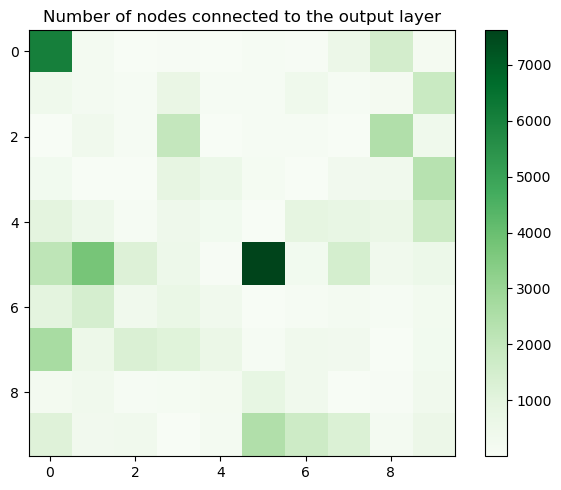

In [3]:
#绘制输出层连接样本数量热力图
clu = np.zeros((M*N, 3))
for i in range(M*N):
    idx = np.argwhere(SOM_cluster == i).squeeze()
    clu[i][0] = np.sum(readmitted[idx] == 0)
    clu[i][1] = np.sum(readmitted[idx] == 1)
    clu[i][2] = np.sum(readmitted[idx] == 2)
total_cnt = np.sum(clu, axis= 1)

plt.imshow(total_cnt.reshape(M, -1), cmap=plt.get_cmap('Greens'))
plt.colorbar() 
plt.tight_layout()
plt.title('Number of nodes connected to the output layer')

In [ ]:
# 绘制竞争层节点距离热力图
D = np.zeros((M,N))
for i in range(M):
    for j in range(N):
        n = i * M + j
        nebor_n = []
        if i > 0:
            nebor_n.append((i - 1) * M + j)
            if j > 0:
                nebor_n.append((i - 1) * M + j - 1)
            elif j < N-1:
                nebor_n.append((i - 1) * M + j + 1)
        elif i < M-1:
            nebor_n.append((i + 1) * M + j)
            if j > 0:
                nebor_n.append((i + 1) * M + j - 1)
            elif j < N-1:
                nebor_n.append((i + 1) * M + j + 1)
        if j > 0:
            nebor_n.append(i * M + j - 1)
        elif j < N-1:
            nebor_n.append(i * M + j + 1)

        nebor_n = np.array(nebor_n)
        data = SOM_w.T[n]
        nebor = SOM_w.T[nebor_n]
        D[i][j] = np.average(edist(data, nebor))

D = D.reshape(M,-1)
plt.figure(figsize=(6, 6),dpi=100)
plt.imshow(D, cmap=plt.cm.Blues)
plt.title('Distance of output layer nodes')    # 图像标题
plt.colorbar() 
plt.xticks(np.arange(N), np.arange(N), rotation=90)    # 将标签印在x轴坐标上
plt.yticks(np.arange(M), np.arange(M))    # 将标签印在y轴坐标上
thresh = D.max() / 2.
for i, j in itertools.product(range(D.shape[0]), range(D.shape[1])):
        num = '{:.2f}'.format(D[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if float(num) > thresh else "black")


In [ ]:
#绘制输出层连接样本分布饼图
#选择要绘制属性
feature = np.array(df.iloc[:,25])

# 有缺失值得数值型属性 idx_mix = [14, 15, 16]
# 数值型属性 idx = [6, 8, 9, 10, 11, 12, 13, 17]
# 替换数值型属性中得缺失值
'''subdata_set = np.array([str(j) for j in feature])
invalid_char = ['V','E','?']
idx_nan = np.array([])
for c in invalid_char:
    char_count = np.char.count(subdata_set, c)
    idx_nan = np.argwhere(char_count != 0).squeeze()
    subdata_set[idx_nan] = '0'
feature = subdata_set.astype(float)'''

#离散型属性统计
feature_type = np.unique(feature)
clu2 = np.zeros((M*N, len(feature_type)))
for i in range(M*N):
    idx = np.argwhere(SOM_cluster == i).squeeze()
    for j in range(len(feature_type)):
       clu2[i][j] = np.sum(feature[idx] == feature_type[j])

#数值型属性统计
'''feature_step = (np.max(feature) - np.min(feature) + 1) / 10
mi = np.min(feature)
clu2 = np.zeros(((M*N), 10))
for i in range(M*N):
    idx = np.argwhere(SOM_cluster == i).squeeze()
    for j in range(10):
        clu2[i][j] = np.sum((feature[idx] > (mi + j * feature_step)) * (feature[idx] < (mi + (j + 1) * feature_step)))'''

#结果绘制
fig,axj=plt.subplots(nrows=M,ncols=N,figsize=(8, 8),dpi=100)
axes = axj.flatten()
for ax in range(M*N):
    axes[ax].pie(x=clu2[ax])
    plt.subplots_adjust()  # 调整子图间距
plt.show()

In [44]:
#计算聚类结果有监督指标
feature = np.array(df.iloc[:,28])

# 有缺失值得数值型属性 idx_mix = [14, 15, 16]
# 数值型属性 idx = [6, 8, 9, 10, 11, 12, 13, 17]
# 替换数值型属性中得缺失值
'''subdata_set = np.array([str(j) for j in feature])
invalid_char = ['V','E','?']
idx_nan = np.array([])
for c in invalid_char:
    char_count = np.char.count(subdata_set, c)
    idx_nan = np.argwhere(char_count != 0).squeeze()
    subdata_set[idx_nan] = '0'
feature = subdata_set.astype(float)'''

#离散型属性统计
feature_type = np.unique(feature)
clu2 = np.zeros((M*N, len(feature_type)))
label = feature.copy()
for i in range(M*N):
    idx = np.argwhere(SOM_cluster == i).squeeze()
    for j in range(len(feature_type)):
       clu2[i][j] = np.sum(feature[idx] == feature_type[j])
    clu_label = np.argmax(clu2[i])
    label[idx] = feature_type[clu_label]

#数值型属性统计
'''feature_step = (np.max(feature) - np.min(feature) + 1) / 10
mi = np.min(feature)
clu2 = np.zeros(((M*N), 10))
feature_label = np.zeros(feature.shape)
label = np.zeros(feature.shape)
for i in range(M*N):
    idx = np.argwhere(SOM_cluster == i).squeeze()
    for j in range(10):
        idx_label = np.argwhere((feature[idx] > (mi + j * feature_step)) * (feature[idx] < (mi + (j + 1) * feature_step)) == True).squeeze()
        clu2[i][j] = np.sum((feature[idx] > (mi + j * feature_step)) * (feature[idx] < (mi + (j + 1) * feature_step)))
        feature_label[idx_label] = j
    label[idx] = np.argmax(clu2[i])'''

#计算指标
ami=adjusted_mutual_info_score(label, feature) 
print('AMI: %f'%(ami))
ari=adjusted_rand_score(label, feature)  
print('ARI: %f'%(ari))
fmi=fowlkes_mallows_score(label, feature)  
print('FMI: %f'%(fmi))

AMI: 0.000190
ARI: 0.000381
FMI: 0.678209


In [67]:
#计算聚类结果无监督指标
sc=silhouette_score(data_set,SOM_cluster)
print('Silhouette score: %f'%(sc))
cks=calinski_harabasz_score(data_set,SOM_cluster)
print('Calinski harabasz score: %f'%(cks))

Silhouette score: -0.164527
Calinski harabasz score: 361.132379
